In [1]:
'''Cell 0. Imports & Reproducibility Setup'''

# Standard library
import os
import random
import time

# Data handling
import numpy as np
import pandas as pd

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

#reporting
from sklearn.metrics import classification_report, confusion_matrix
from captum.attr import IntegratedGradients

# Visualization
import matplotlib.pyplot as plt

# Progress bars (optional)
from tqdm.auto import tqdm


from collections import Counter

# ——————————————————————————
# Reproducible runs: fix all RNGs
# ——————————————————————————
SEED = 45  # fixed seed for deterministic behavior

# Python built-in RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch CPU RNG
torch.manual_seed(SEED)

# PyTorch GPU RNGs (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

print(f"🔒 RNG seeds set to {SEED} (random, NumPy, PyTorch CPU/GPU)")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


🔒 RNG seeds set to 45 (random, NumPy, PyTorch CPU/GPU)
Using device: cuda


In [2]:
'''Cell 1. Load and Validate the Labeled Dataset'''

#import pandas as pd


'''try:
    # Attempt to read the labeled dataset
    full_df = pd.read_csv('data\processed\dataset.csv')
    print("✅ Successfully loaded: 'dataset.csv'")
    print(f"Total rows: {len(full_df)}")
    print(f"Unique coupons: {full_df['coupon_id'].nunique()}")

    # Check for missing labels
    if full_df['Label'].isnull().any():
        print("⚠️ Warning: Found NaN values in the 'Label' column. Please ensure all coupons are labeled.")
        # Optional fix:
        # full_df.dropna(subset=['Label'], inplace=True)
        # print(f"Rows after dropping NaN labels: {len(full_df)}")
    else:
        print("✅ Label column verified: no missing values.")

    # Ensure all labels are integers
    full_df['Label'] = full_df['Label'].astype(int)

except FileNotFoundError:
    print("❌ Error: 'dataset.csv' not found.")
    print("Please ensure the dataset file exists in the working directory.")
    raise FileNotFoundError("Could not find the required 'dataset.csv' file.")'''

# Assumes this notebook is inside the 'notebooks' folder.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'dataset.csv')

try:
    full_df = pd.read_csv(PROCESSED_DATA_PATH)
    print(f"✅ Successfully loaded: '{PROCESSED_DATA_PATH}'")
    print(f"Total rows: {len(full_df)}")
    print(f"Unique coupons: {full_df['coupon_id'].nunique()}")

    if full_df['Label'].isnull().any():
        print("⚠️ Warning: Found NaN values in the 'Label' column.")
    else:
        print("✅ Label column verified: no missing values.")

    full_df['Label'] = full_df['Label'].astype(int)

except FileNotFoundError:
    print(f"❌ Error: '{PROCESSED_DATA_PATH}' not found.")
    raise FileNotFoundError(f"Could not find the required '{PROCESSED_DATA_PATH}' file.")


✅ Successfully loaded: 'f:\Prof. Nick\LPBF_defect_project\data\processed\dataset.csv'
Total rows: 15633
Unique coupons: 60
✅ Label column verified: no missing values.


In [3]:
'''Cell 2. Feature Selection and Standard Scaling'''
#from sklearn.preprocessing import StandardScaler

# Drop any columns that contain '(MT)' or '(PB)' in the name
# - (MT) for metadata based features, (PB) for parameter based features
# - Not including these featuresfor machine learning here. filter out
full_df.drop(
    columns=[col for col in full_df.columns if '(MT)' in col or '(PB)' in col],
    inplace=True
)

# Feature scaling
# Not including non-feature columns for scaling 
feature_cols = [col for col in full_df.columns if col not in ['coupon_id', 'layer_index', 'Label']]

# Dynamically set the INPUT_SIZE for the model based on the number of selected features
INPUT_SIZE = len(feature_cols)
print(f"✅ Dynamically selected {INPUT_SIZE} feature columns for model training.")

# Scale the feature columns. Standard scaling (zero mean, unit variance)
scaler = StandardScaler()
full_df[feature_cols] = scaler.fit_transform(full_df[feature_cols])

# Summary
print(f"✅ Selected and scaled {len(feature_cols)} feature columns:")
print(f"{feature_cols}")
print("✅ Features ready for model input.")

✅ Dynamically selected 76 feature columns for model training.
✅ Selected and scaled 76 feature columns:
['MeltVIEW plasma_mean', 'MeltVIEW plasma_std', 'MeltVIEW plasma_min', 'MeltVIEW plasma_max', 'MeltVIEW plasma_ptp', 'MeltVIEW plasma_skew', 'MeltVIEW plasma_kurtosis', 'MeltVIEW plasma_mad', 'MeltVIEW plasma_extreme_count', 'MeltVIEW plasma_entropy', 'MeltVIEW plasma_glcm_contrast_mean', 'MeltVIEW plasma_glcm_contrast_std', 'MeltVIEW plasma_glcm_homogeneity_mean', 'MeltVIEW plasma_glcm_homogeneity_std', 'MeltVIEW plasma_glcm_energy_mean', 'MeltVIEW plasma_glcm_energy_std', 'MeltVIEW plasma_glcm_correlation_mean', 'MeltVIEW plasma_glcm_correlation_std', 'MeltVIEW plasma_glcm_entropy_mean', 'MeltVIEW plasma_glcm_entropy_std', 'MeltVIEW plasma_hot_clusters', 'MeltVIEW plasma_hot_abs_contrast', 'MeltVIEW plasma_hot_rel_contrast', 'MeltVIEW plasma_hot_rel_size', 'MeltVIEW plasma_cold_clusters', 'MeltVIEW plasma_cold_abs_contrast', 'MeltVIEW plasma_cold_rel_contrast', 'MeltVIEW plasma_col

In [4]:
'''Cell 3. Sequence construction for Validation/Test shuffled split Dictionaries'''
#import torch
#from sklearn.model_selection import GroupShuffleSplit
#from collections import Counter

# Construct one sequence per coupon:
#    - Group the DataFrame by 'coupon_id'
#    - For each group, extract the feature matrix (layers × features)
#      and the single coupon-level label
all_labeled_list = []
for coupon_id, group in full_df.groupby('coupon_id'):
    seq_array   = group[feature_cols].values                     # NumPy array shape: (num_layers, num_features)
    coupon_label = int(group['Label'].iloc[0])                   # One label per coupon

    all_labeled_list.append({
        'coupon_id': coupon_id,
        'sequence':  torch.tensor(seq_array, dtype=torch.float32),
        'label':     torch.tensor(coupon_label, dtype=torch.long)
    })

print(f"✅ Built all_labeled_list with {len(all_labeled_list)} coupons.")

# Prepare for a group-aware train/validation split:
#    - Preserve entire coupons (no layer leakage)
#    - Hold out 'val_size' coupons for validation
coupon_ids = [entry['coupon_id'] for entry in all_labeled_list]
labels     = [entry['label'].item()         for entry in all_labeled_list]  # for reporting only

val_size   = 10
test_frac  = val_size / len(all_labeled_list)

gss        = GroupShuffleSplit(n_splits=1, test_size=test_frac, random_state=42)
train_idx, val_idx = next(gss.split(all_labeled_list, groups=coupon_ids))

# Split the list of coupon-dicts into train / validation lists
train_list = [all_labeled_list[i] for i in train_idx]
val_list   = [all_labeled_list[i] for i in val_idx]

print(f"\n✅ Split complete:")
print(f"   • Training coupons:   {len(train_list)}")
print(f"   • Validation coupons: {len(val_list)}")

# Report class balance in each set for transparency
train_counts = Counter(int(item['label']) for item in train_list)
val_counts   = Counter(int(item['label']) for item in val_list)
print(f"   • Training label distribution:   {train_counts}")
print(f"   • Validation label distribution: {val_counts}")


✅ Built all_labeled_list with 60 coupons.

✅ Split complete:
   • Training coupons:   50
   • Validation coupons: 10
   • Training label distribution:   Counter({1: 39, 2: 7, 0: 4})
   • Validation label distribution: Counter({1: 8, 0: 1, 2: 1})


In [5]:
'''Cell 4. Dataset, Collate Function, and DataLoader Initialization'''
#import torch
#from torch.utils.data import Dataset, DataLoader
#from torch.nn.utils.rnn import pad_sequence

# 1) Define a PyTorch Dataset wrapper
class LPBFDataset(Dataset):
    """
    Wraps a list of {'sequence': Tensor, 'label': Tensor} dicts 
    so that PyTorch can index and batch them.
    """
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Returns: (sequence, label)
        return self.data_list[idx]['sequence'], self.data_list[idx]['label']


# 2) Collate function to pad variable-length sequences
def collate_fn_supervised(batch):
    """
    batch: list of (sequence, label) tuples
    Returns a dict containing:
      - sequences: padded Tensor (B, T_max, F)
      - lengths:   LongTensor of true lengths (B,)
      - masks:     BoolTensor mask of valid timesteps (B, T_max)
      - labels:    LongTensor of coupon labels (B,)
    """
    sequences, labels = zip(*batch)

    # a) Compute true lengths before padding
    lengths = torch.tensor([len(s) for s in sequences], dtype=torch.long)

    # b) Pad sequences to the length of the longest in this batch
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    # c) Stack labels into a single tensor
    labels_tensor = torch.stack(labels)

    # d) Create a mask that is True for real data, False for padding
    max_len = padded_sequences.size(1)
    masks = torch.arange(max_len)[None, :] < lengths[:, None]

    return {
        'sequences': padded_sequences,
        'lengths':   lengths,
        'masks':     masks,
        'labels':    labels_tensor
    }


# 3) Instantiate Datasets and DataLoaders

# Hyperparameters
BATCH_SIZE_TRAIN = 8                       # number of coupons per training batch
BATCH_SIZE_VAL   = len(val_list)           # one batch for all validation coupons

# Create Dataset objects
train_dataset = LPBFDataset(train_list)
val_dataset   = LPBFDataset(val_list)

# Create DataLoader objects
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,             # shuffle coupons each epoch
    collate_fn=collate_fn_supervised,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE_VAL,
    shuffle=False,            # no shuffle for validation
    collate_fn=collate_fn_supervised,
    num_workers=0
)

print(f"✅ DataLoaders ready:")
print(f"    • train_loader: {len(train_loader)} batches (batch size = {BATCH_SIZE_TRAIN})")
print(f"    • val_loader:   {len(val_loader)} batch(es) (batch size = {BATCH_SIZE_VAL})")
print("✔️  Data preparation complete and ready for model training.")


✅ DataLoaders ready:
    • train_loader: 7 batches (batch size = 8)
    • val_loader:   1 batch(es) (batch size = 10)
✔️  Data preparation complete and ready for model training.


In [6]:
'''Cell 5. Define SemiSupLSTM Model Class'''
#import torch
#import torch.nn as nn
#from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


print("--- Defining SemiSupLSTM model class ---")

class SemiSupLSTM(nn.Module):
    """
    LSTM-based classifier that supports both:
      • many-to-one (coupon-level) via pooling
      • many-to-many (layer-level) outputs for plotting
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
        dropout_lstm: float = 0.0,
        dropout_fc:  float = 0.5,
        pooling_type: str   = 'mean'
    ):
        super().__init__()
        self.input_size   = input_size
        self.hidden_size  = hidden_size
        self.num_layers   = num_layers
        self.num_classes  = num_classes
        self.pooling_type = pooling_type.lower()
        if self.pooling_type not in ('mean', 'max'):
            raise ValueError("pooling_type must be 'mean' or 'max'")
        
        # Core LSTM: batch_first, optional inter-layer dropout
        self.lstm = nn.LSTM(
            input_size  = input_size,
            hidden_size = hidden_size,
            num_layers  = num_layers,
            batch_first = True,
            dropout     = dropout_lstm if num_layers > 1 else 0.0,
            bidirectional = False
        )
        
        # Dropout before final classification
        self.dropout = nn.Dropout(p=dropout_fc)
        
        # Final linear layer to produce class logits
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(
        self,
        sequences: torch.Tensor,    # (batch, max_len, input_size)
        lengths:   torch.LongTensor, # (batch,) true lengths
        masks:     torch.BoolTensor, # (batch, max_len)
        return_all_outputs: bool = False
    ) -> torch.Tensor:
        """
        Forward pass.
        If return_all_outputs=True, returns per-layer logits:
            (batch, max_len, num_classes)
        Else, returns pooled coupon-level logits:
            (batch, num_classes)
        """
        # 1) Pack padded sequences for efficient LSTM processing
        packed = pack_padded_sequence(
            sequences, lengths.cpu(),
            batch_first=True, enforce_sorted=False
        )
        
        # 2) Run through LSTM
        packed_out, _ = self.lstm(packed)
        lstm_out, _  = pad_packed_sequence(packed_out, batch_first=True)
        # lstm_out: (batch, max_len, hidden_size)

        # 3A) Many-to-many: per-step outputs for plotting
        if return_all_outputs:
            dropped = self.dropout(lstm_out)                            # dropout on each hidden state
            flat    = dropped.reshape(-1, self.hidden_size)            # (batch*max_len, hidden_size)
            logits  = self.fc(flat)                                     # (batch*max_len, num_classes)
            return logits.view(sequences.size(0), sequences.size(1), -1)  # (batch, max_len, num_classes)

        # 3B) Many-to-one: pool hidden states for coupon-level prediction
        #    Mask padding then pool across time
        mask_f = masks.unsqueeze(-1).float()      # (batch, max_len, 1)
        masked = lstm_out * mask_f                # zero out padding
        
        if self.pooling_type == 'mean':
            summed = masked.sum(dim=1)            # sum over time → (batch, hidden_size)
            lengths_f = lengths.unsqueeze(-1).float().to(summed.device)
            pooled = summed / (lengths_f + 1e-8)  # mean over valid timesteps
        else:  # max pooling
            # set padded positions to -inf so they don’t affect the max
            mask_b = masks.unsqueeze(-1).expand_as(masked)
            tmp    = masked.clone()
            tmp[~mask_b] = -float('inf')
            pooled, _ = tmp.max(dim=1)            # (batch, hidden_size)
            pooled    = torch.nan_to_num(pooled, neginf=0.0)

        # 4) Final dropout + classification
        out = self.dropout(pooled)                # (batch, hidden_size)
        return self.fc(out)                       # (batch, num_classes)
        
print("SemiSupLSTM model class defined successfully.")


--- Defining SemiSupLSTM model class ---
SemiSupLSTM model class defined successfully.


In [7]:
'''Cell 6. Model, Loss & Optimizer Setup'''

#import torch
#import torch.nn as nn
#import torch.optim as optim
#from collections import Counter

# 1) Quick sanity checks (fail fast if run out of order)
assert 'train_list' in globals(), "Run data prep before this cell (missing train_list)."
assert 'SemiSupLSTM' in globals(), "Define SemiSupLSTM model before this cell."

# 2) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"▶ Using device: {device}")

# 3) Hyperparameters
INPUT_SIZE       = INPUT_SIZE  # length of the feature vector. 76 in this case. length dynamically coded to be extracted.
HIDDEN_SIZE      = 128
NUM_LSTM_LAYERS  = 1
NUM_CLASSES      = 3
DROPOUT_LSTM     = 0.0
DROPOUT_FC       = 0.5
POOLING_TYPE     = 'mean'
LEARNING_RATE    = 1e-4
WEIGHT_DECAY     = 1e-4

# 4) Model instantiation
model = SemiSupLSTM(
    input_size   = INPUT_SIZE,
    hidden_size  = HIDDEN_SIZE,
    num_layers   = NUM_LSTM_LAYERS,
    num_classes  = NUM_CLASSES,
    dropout_lstm = DROPOUT_LSTM,
    dropout_fc   = DROPOUT_FC,
    pooling_type = POOLING_TYPE
).to(device)
print("✔ Model created.")

# 5) Class weights (optional)
train_labels = [int(item['label']) for item in train_list]
counts = Counter(train_labels)
total = len(train_labels)
class_weights = [
    total / (NUM_CLASSES * counts.get(c, 1))
    for c in range(NUM_CLASSES)
]
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"✔ Loss: CrossEntropyLoss with weights {class_weights.tolist()}")

# 6) Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
print(f"✔ Optimizer: AdamW(lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")


▶ Using device: cuda
✔ Model created.
✔ Loss: CrossEntropyLoss with weights [4.166666507720947, 0.4273504316806793, 2.3809523582458496]
✔ Optimizer: AdamW(lr=0.0001, weight_decay=0.0001)


In [8]:
'''Cell 7. Define verbose validation function'''

#from sklearn.metrics import classification_report, confusion_matrix
#import torch
#import numpy as np
#import pandas as pd

# Class labels for reporting
target_names = ['LOF(0)', 'GOOD(1)', 'KEYHOLE(2)']
num_classes = len(target_names)

def validate(model, val_loader, criterion, device, verbose: bool = True):
    """
    Evaluate the model on the validation set, computing loss and classification metrics.

    Args:
        model (nn.Module): Trained LSTM model.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss).
        device (torch.device): CPU or CUDA device.
        verbose (bool): If True, prints detailed metrics and confusion matrix.

    Returns:
        avg_loss (float): Mean validation loss over all batches.
        metrics (dict):
            'accuracy' (float): Overall accuracy.
            'report' (dict): Detailed precision/recall/F1 per class.
    """
    model.eval()  # disable dropout, batchnorm, etc.
    total_val_loss = 0.0
    all_preds, all_labels = [], []
    batch_count = 0

    # Iterate over validation batches without gradient tracking
    with torch.no_grad():
        for batch in val_loader:
            # Move data to the correct device
            seqs    = batch['sequences'].to(device)
            labels  = batch['labels'].to(device)
            lengths = batch['lengths']
            masks   = batch['masks'].to(device)

            # Forward pass and accumulate loss
            logits = model(seqs, lengths, masks)
            total_val_loss += criterion(logits, labels).item()
            batch_count += 1

            # Collect predicted and true labels
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average loss and accuracy
    avg_loss = total_val_loss / batch_count if batch_count else 0.0
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() if all_labels else 0.0

    if verbose:
        # Print summary statistics
        print(f"\nValidation Results:  Avg Loss={avg_loss:.4f}, Acc={accuracy:.4f}\n")

        # Detailed classification report
        print("Classification Report:")
        print(classification_report(
            all_labels, all_preds,
            labels=range(num_classes),
            target_names=target_names,
            zero_division=0
        ))

        # Confusion matrix as DataFrame
        cm = confusion_matrix(
            all_labels, all_preds,
            labels=range(num_classes)
        )
        print("Confusion Matrix:")
        cm_df = pd.DataFrame(
            cm,
            index=[f"True_{n}" for n in target_names],
            columns=[f"Pred_{n}" for n in target_names]
        )
        display(cm_df)

    # Always return metrics dictionary
    report_dict = classification_report(
        all_labels, all_preds,
        labels=range(num_classes),
        target_names=target_names,
        output_dict=True,
        zero_division=0
    ) if all_labels else {}

    return avg_loss, {'accuracy': accuracy, 'report': report_dict}

print("Verbose validation function ready.")



Verbose validation function ready.


In [9]:
'''Cell 8. Supervised Training Loop with Early Stopping'''

#import os
#import time
#import torch
#from tqdm.notebook import tqdm
#import pandas as pd

print("--- Running: Supervised Training Loop ---")

# --- Path to save the best model ---

# 1) Sanity checks
required = [
    'model', 'optimizer', 'criterion',
    'train_loader', 'val_loader',
    'validate', 'device',
    'train_list', 'val_list'
]
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing required components: {missing}")

# 2) Metrics history
history = {
    'epoch': [], 'train_loss': [], 'val_loss': [], 'val_acc': [],
    'val_f1_macro': [], 'val_f1_weighted': [],
    'val_f1_lof': [], 'val_f1_good': [], 'val_f1_keyhole': []
}


# 3) Early stopping configuration
NUM_EPOCHS    = 200         # maximum epochs
PATIENCE      = 15          # epochs to wait for improvement
MIN_DELTA     = 1e-5        # minimal change to qualify as improvement
patience_ctr  = 0           # counter for no-improvement epochs
best_val_acc  = -float('inf')
#best_model_fp = 'best_supervised_model.pth'
saved_epoch   = 0

MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, 'models')
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
best_model_fp = os.path.join(MODEL_SAVE_DIR, 'best_supervised_model.pth')

print(f"\nTraining up to {NUM_EPOCHS} epochs with early stopping (patience={PATIENCE}).")
print(f"Best model checkpoint will be saved to: {best_model_fp}\n")

start_time = time.time()

# 4) Epoch loop with progress bar
for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Epochs", leave=True):
    model.train()
    train_loss_accum = 0.0
    batch_idx = 0

    # 4a) Training phase: per-batch loop with running loss
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]", leave=False)
    for batch in train_bar:
        batch_idx += 1
        # Move batch data to device
        seqs    = batch['sequences'].to(device)
        lengths = batch['lengths']
        masks   = batch['masks'].to(device)
        labels  = batch['labels'].to(device)

        # Forward, backward, optimize
        optimizer.zero_grad()
        logits = model(seqs, lengths, masks)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # Update running loss and progress bar
        train_loss_accum += loss.item()
        avg_so_far = train_loss_accum / batch_idx
        train_bar.set_postfix(train_loss=f"{avg_so_far:.4f}")

        

    avg_train_loss = train_loss_accum / len(train_loader)
    #print(f"\n▶ Epoch {epoch}: Avg Train Loss = {avg_train_loss:.4f}")

    # 4b) Validation phase (silent)
    val_loss, val_metrics = validate(model, val_loader, criterion, device, verbose=False)
    val_acc = val_metrics['accuracy']
    report  = val_metrics['report']

    # 4c) Record metrics in history
    history['epoch'].append(epoch)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1_macro'].append(report.get('macro avg', {}).get('f1-score', 0.0))
    history['val_f1_weighted'].append(report.get('weighted avg', {}).get('f1-score', 0.0))
    history['val_f1_lof'].append(report.get('LOF(0)', {}).get('f1-score', 0.0))
    history['val_f1_good'].append(report.get('GOOD(1)', {}).get('f1-score', 0.0))
    history['val_f1_keyhole'].append(report.get('KEYHOLE(2)', {}).get('f1-score', 0.0))

    # # 4d) Early stopping: save best model and count patience
    if val_acc > best_val_acc + MIN_DELTA:
        #print(f"Validation accuracy improved ({best_val_acc:.4f} → {val_acc:.4f}). Saving model.")
        best_val_acc = val_acc
        patience_ctr  = 0
        saved_epoch   = epoch
        torch.save(model.state_dict(), best_model_fp)
    else:
        patience_ctr += 1
        #print(f"No improvement ({best_val_acc:.4f} best) for {patience_ctr}/{PATIENCE} epochs.")

    if patience_ctr >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch}.")
        break

# 5) End of training
elapsed = time.time() - start_time
print(f"\nTraining complete in {elapsed:.1f}s (stopped at epoch {epoch}).")

# 6) Load best model and final verbose validation
if os.path.exists(best_model_fp):
    print(f"\nLoading best model from epoch {saved_epoch} (val_acc={best_val_acc:.4f}).")
    model.load_state_dict(torch.load(best_model_fp))
else:
    print("\nBest model file not found; using current model state.")

print("\n--- Final Validation on Best/Final Model ---")
_, final_metrics = validate(model, val_loader, criterion, device, verbose=True)

# 7) Display last 10 epochs of training history
print("\n--- Training History (last 10 epochs) ---")
history_df = pd.DataFrame(history)
display(history_df.tail(10))


--- Running: Supervised Training Loop ---

Training up to 200 epochs with early stopping (patience=15).
Best model checkpoint will be saved to: f:\Prof. Nick\LPBF_defect_project\models\best_supervised_model.pth



Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 51/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 52/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 53/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 54/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 55/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 56/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 57/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 58/200 [Train]:   0%|          | 0/7 [00:00<?, ?it/s]


Early stopping triggered at epoch 58.

Training complete in 6.7s (stopped at epoch 58).

Loading best model from epoch 43 (val_acc=1.0000).

--- Final Validation on Best/Final Model ---

Validation Results:  Avg Loss=0.5476, Acc=1.0000

Classification Report:
              precision    recall  f1-score   support

      LOF(0)       1.00      1.00      1.00         1
     GOOD(1)       1.00      1.00      1.00         8
  KEYHOLE(2)       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix:


,Pred_LOF(0),Pred_GOOD(1),Pred_KEYHOLE(2)
True_LOF(0),1,0,0
True_GOOD(1),0,8,0
True_KEYHOLE(2),0,0,1



--- Training History (last 10 epochs) ---


,epoch,train_loss,val_loss,val_acc,val_f1_macro,val_f1_weighted,val_f1_lof,val_f1_good,val_f1_keyhole
48,49,0.327988,0.450609,1.0,1.0,1.0,1.0,1.0,1.0
49,50,0.261061,0.433895,1.0,1.0,1.0,1.0,1.0,1.0
50,51,0.263338,0.416857,1.0,1.0,1.0,1.0,1.0,1.0
51,52,0.205593,0.398062,1.0,1.0,1.0,1.0,1.0,1.0
52,53,0.187811,0.382237,1.0,1.0,1.0,1.0,1.0,1.0
53,54,0.191743,0.366788,1.0,1.0,1.0,1.0,1.0,1.0
54,55,0.181990,0.357066,1.0,1.0,1.0,1.0,1.0,1.0
55,56,0.170609,0.344404,1.0,1.0,1.0,1.0,1.0,1.0
56,57,0.143943,0.333658,1.0,1.0,1.0,1.0,1.0,1.0
57,58,0.108889,0.322008,1.0,1.0,1.0,1.0,1.0,1.0


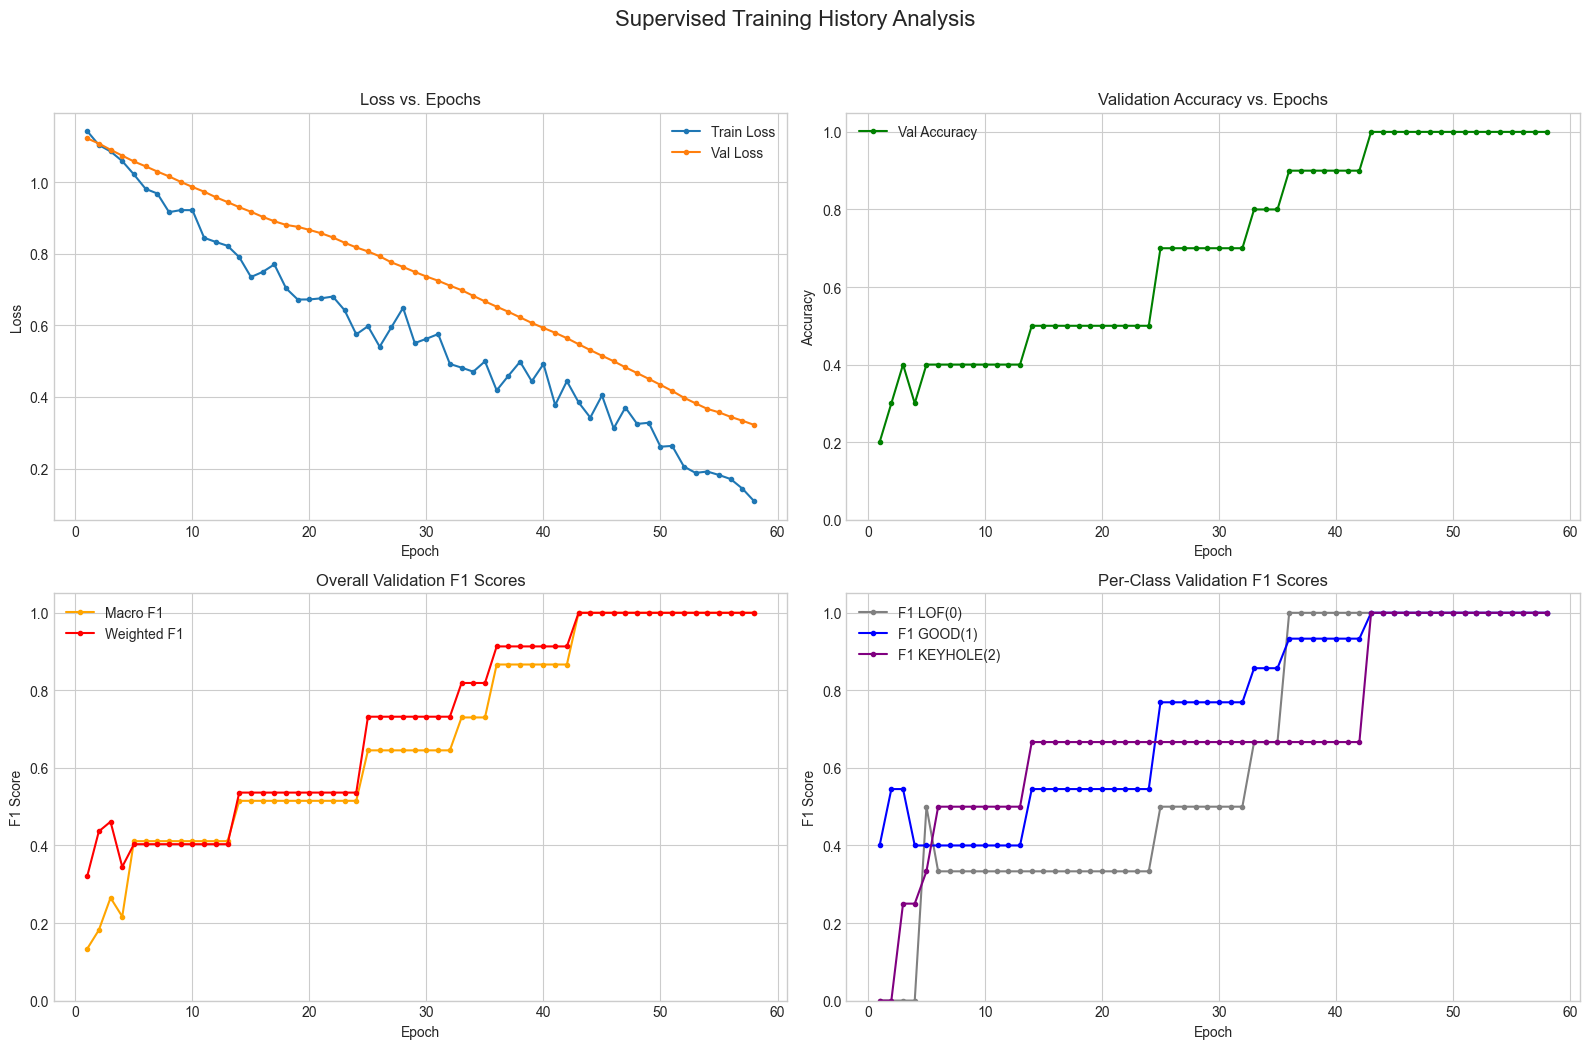

Plotted training history: loss, accuracy, macro/weighted F1, and per-class F1.


In [10]:
'''Cell 9. Plot Supervised Training History'''


#import matplotlib.pyplot as plt

# Apply whitegrid style for clarity
plt.style.use('seaborn-v0_8-whitegrid')

# Create a 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Supervised Training History Analysis', fontsize=16)

# Top-left: Training vs. Validation Loss
ax = axes[0, 0]
ax.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', marker='.')
ax.plot(history_df['epoch'], history_df['val_loss'],   label='Val Loss',   marker='.')
ax.set(title='Loss vs. Epochs', xlabel='Epoch', ylabel='Loss')
ax.legend()
ax.grid(True)

# Top-right: Validation Accuracy over epochs
ax = axes[0, 1]
ax.plot(history_df['epoch'], history_df['val_acc'], label='Val Accuracy', marker='.', color='green')
ax.set(title='Validation Accuracy vs. Epochs', xlabel='Epoch', ylabel='Accuracy')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(True)

# Bottom-left: Overall F1 Scores (Macro and Weighted)
ax = axes[1, 0]
ax.plot(history_df['epoch'], history_df['val_f1_macro'],    label='Macro F1',    marker='.', color='orange')
ax.plot(history_df['epoch'], history_df['val_f1_weighted'], label='Weighted F1', marker='.', color='red')
ax.set(title='Overall Validation F1 Scores', xlabel='Epoch', ylabel='F1 Score')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(True)

# Bottom-right: Per-Class F1 Scores
ax = axes[1, 1]
ax.plot(history_df['epoch'], history_df['val_f1_lof'],     label='F1 LOF(0)',     marker='.', color='grey')
ax.plot(history_df['epoch'], history_df['val_f1_good'],    label='F1 GOOD(1)',    marker='.', color='blue')
ax.plot(history_df['epoch'], history_df['val_f1_keyhole'], label='F1 KEYHOLE(2)', marker='.', color='purple')
ax.set(title='Per-Class Validation F1 Scores', xlabel='Epoch', ylabel='F1 Score')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(True)

# Adjust layout and render
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close(fig)

# Documentation note
print("Plotted training history: loss, accuracy, macro/weighted F1, and per-class F1.")


--- Running: Plotting Per-Layer Probabilities ---

Loaded model from 'f:\Prof. Nick\LPBF_defect_project\models\best_supervised_model.pth'.

Class 'LOF(0)' — sample index 1:


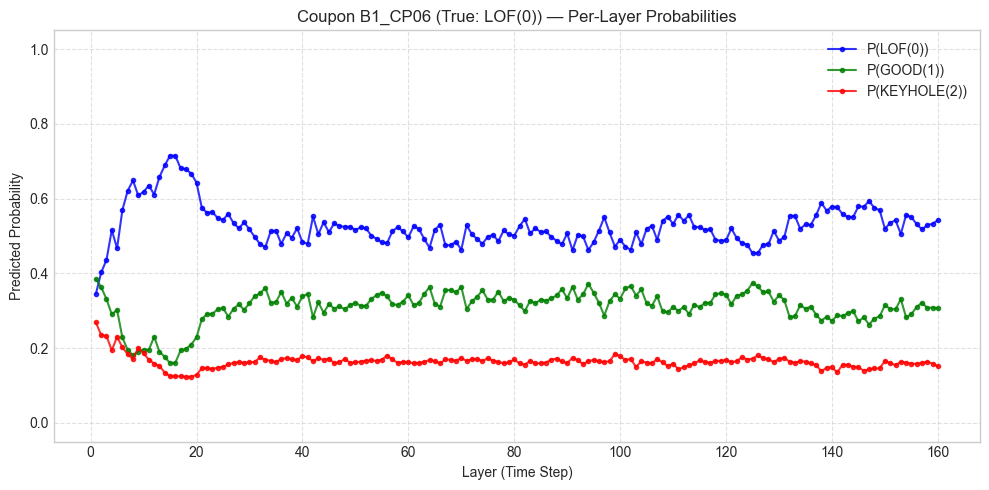

------------------------------------------------------------
Class 'GOOD(1)' — sample index 0:


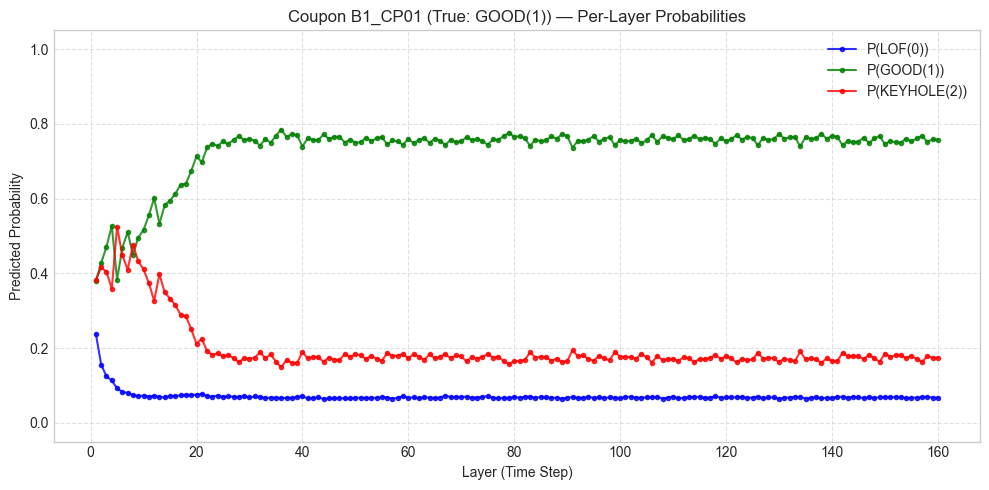

------------------------------------------------------------
Class 'KEYHOLE(2)' — sample index 4:


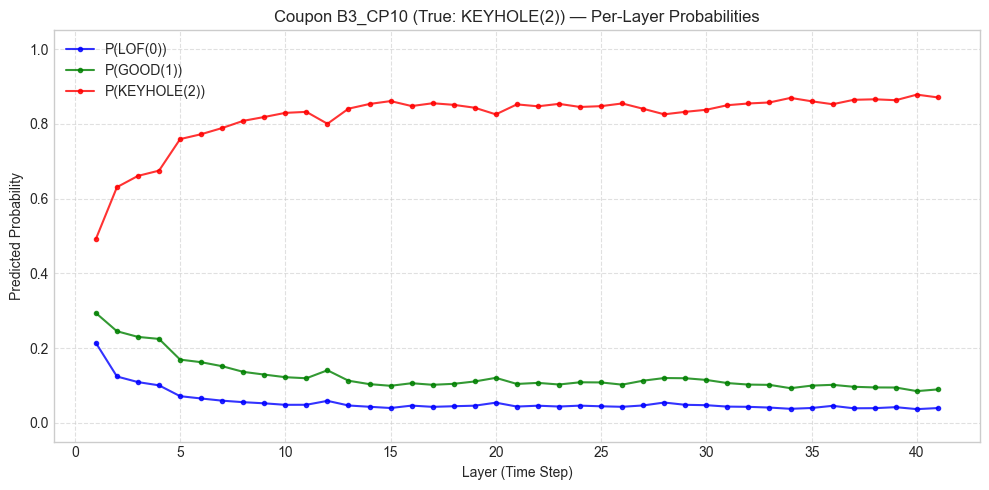

------------------------------------------------------------


In [11]:
'''Cell 10. Plot Per-Layer Prediction Probabilities'''


#import os
#import torch
#import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd

print("--- Running: Plotting Per-Layer Probabilities ---\n")

# 1) Configuration
best_model_path = best_model_fp   # trained checkpoint
val_list_to_use = val_list                    # validation samples list

# 2) Identify one sample index per class in the validation set
lof_idx, good_idx, keyhole_idx = -1, -1, -1
for i, item in enumerate(val_list_to_use):
    label = int(item['label'].item())
    if label == 0 and lof_idx == -1:
        lof_idx = i
    elif label == 1 and good_idx == -1:
        good_idx = i
    elif label == 2 and keyhole_idx == -1:
        keyhole_idx = i

sample_indices = {0: lof_idx, 1: good_idx, 2: keyhole_idx}

# 3) Load the trained model for plotting
#    Re-create architecture with the same hyperparameters
if 'MODEL_PARAMS' not in locals():
    MODEL_PARAMS = {
        'input_size':    INPUT_SIZE,
        'hidden_size':   HIDDEN_SIZE,
        'num_layers':    NUM_LSTM_LAYERS,
        'num_classes':   NUM_CLASSES,
        'dropout_lstm':  DROPOUT_LSTM,
        'dropout_fc':    DROPOUT_FC,
        'pooling_type':  POOLING_TYPE
    }
model_plot = SemiSupLSTM(**MODEL_PARAMS)
model_loaded = False

if os.path.exists(best_model_path):
    model_plot.load_state_dict(torch.load(best_model_path, map_location='cpu'))
    model_plot.to(device).eval()
    model_loaded = True
    print(f"Loaded model from '{best_model_path}'.\n")
else:
    print(f"Error: checkpoint '{best_model_path}' not found.\n")

# 4) Plot per-layer probabilities for each class sample
if model_loaded:
    dataset_plot = LPBFDataset(val_list_to_use)

    # Choose plot colors for classes: LOF=blue, GOOD=green, KEYHOLE=red
    plot_colors = ['blue', 'green', 'red']

    for cls in range(NUM_CLASSES):
        idx = sample_indices[cls]
        if idx < 0:
            print(f"Skipping class {target_names[cls]}: no sample found.")
            continue

        print(f"Class '{target_names[cls]}' — sample index {idx}:")
        seq_tensor, label_tensor = dataset_plot[idx]
        coupon_id = val_list_to_use[idx]['coupon_id']
        true_label = label_tensor.item()

        # Collate into a batch of size 1
        batch = collate_fn_supervised([(seq_tensor, label_tensor)])
        seqs    = batch['sequences'].to(device)
        lengths = batch['lengths']
        masks    = batch['masks'].to(device)

        # Compute logits for all time-steps, then softmax to get probabilities
        with torch.no_grad():
            all_logits = model_plot(seqs, lengths, masks, return_all_outputs=True)
            all_probs  = torch.softmax(all_logits, dim=-1)

        # Trim padding: only keep real time-steps
        T = lengths.item()
        probs = all_probs[0, :T, :].cpu().numpy()

        # 5) Plotting
        plt.figure(figsize=(10, 5))
        ts = np.arange(1, T+1)
        for c in range(NUM_CLASSES):
            plt.plot(ts, probs[:, c],
                     label=f"P({target_names[c]})",
                     color=plot_colors[c],
                     marker='.', alpha=0.8)

        plt.title(f"Coupon {coupon_id} (True: {target_names[true_label]}) — Per-Layer Probabilities")
        plt.xlabel("Layer (Time Step)")
        plt.ylabel("Predicted Probability")
        plt.ylim(-0.05, 1.05)
        plt.legend(loc='best')
        plt.grid(linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        plt.close()

        print("-" * 60)

else:
    print("Model not loaded; skipping per-layer probability plots.")



→ IG for class LOF(0) (idx=0)
  Top 15 features:
     1. (PD)_MVP/TE_ratio: 0.7157
     2. (PD)_MVP/MVMP_ratio: 0.5925
     3. (PDPB)_MVMP/VED: 0.5017
     4. MeltVIEW plasma_cold_rel_contrast: 0.4579
     5. (PDPB)_TotalEnergy/VED: 0.4553
     6. MeltVIEW plasma_mean: 0.4497
     7. MeltVIEW melt pool_glcm_correlation_std: 0.3904
     8. LaserVIEW_entropy: 0.3864
     9. MeltVIEW plasma_glcm_correlation_mean: 0.3675
    10. MeltVIEW plasma_hot_clusters: 0.3541
    11. LaserVIEW_std: 0.3498
    12. MeltVIEW plasma_glcm_contrast_mean: 0.3381
    13. MeltVIEW melt pool_glcm_contrast_std: 0.3168
    14. (PD)_MVP/LV: 0.3028
    15. (PDPB)_LV/LP: 0.2961


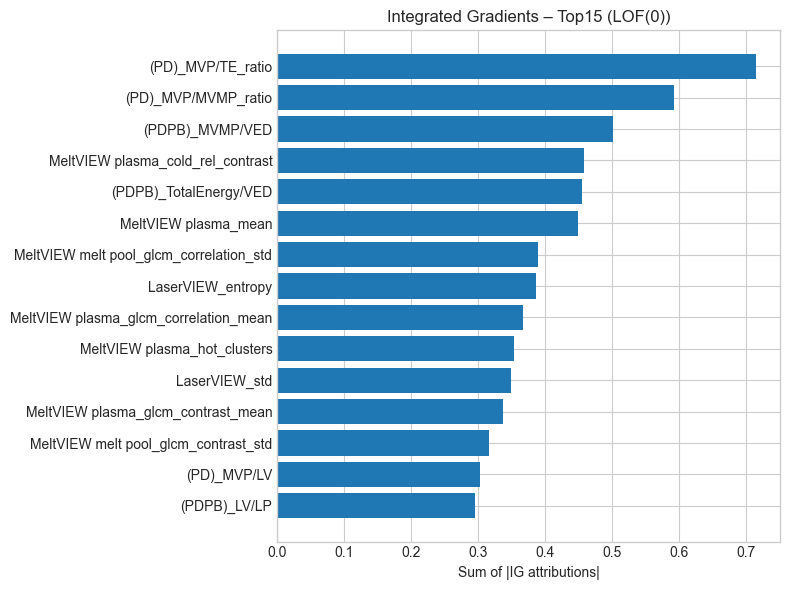

------------------------------------------------------------

→ IG for class GOOD(1) (idx=1)
  Top 15 features:
     1. (PD)_MVP/MVMP_ratio: 0.8676
     2. (PD)_MVP/TE_ratio: 0.6981
     3. LaserVIEW_skew: 0.5229
     4. MeltVIEW plasma_cold_clusters: 0.4617
     5. LaserVIEW_ptp: 0.4509
     6. MeltVIEW plasma_glcm_energy_mean: 0.4160
     7. LaserVIEW_entropy: 0.4097
     8. MeltVIEW plasma_entropy: 0.3869
     9. MeltVIEW plasma_hot_rel_contrast: 0.3693
    10. LaserVIEW_mad: 0.3292
    11. LaserVIEW_mean: 0.3133
    12. MeltVIEW melt pool_cold_abs_contrast: 0.2994
    13. (PDPB)_MVP/VED: 0.2986
    14. MeltVIEW melt pool_extreme_count: 0.2895
    15. MeltVIEW plasma_glcm_correlation_std: 0.2789


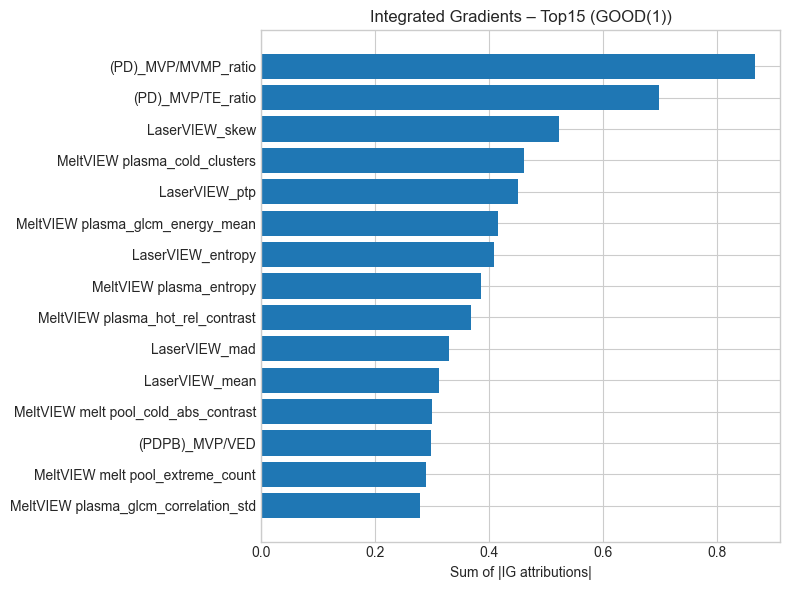

------------------------------------------------------------

→ IG for class KEYHOLE(2) (idx=2)
  Top 15 features:
     1. LaserVIEW_mean: 0.4721
     2. MeltVIEW plasma_mad: 0.4553
     3. MeltVIEW plasma_mean: 0.4331
     4. MeltVIEW melt pool_glcm_correlation_std: 0.4263
     5. LaserVIEW_mad: 0.3985
     6. MeltVIEW melt pool_max: 0.3972
     7. MeltVIEW plasma_hot_rel_contrast: 0.3849
     8. MeltVIEW plasma_std: 0.3835
     9. (PDPB)_LV/LP: 0.3748
    10. LaserVIEW_entropy: 0.3668
    11. LaserVIEW_max: 0.3513
    12. MeltVIEW plasma_ptp: 0.3438
    13. (PD)_Total_Energy: 0.3285
    14. (PDPB)_MVMP/VED: 0.3255
    15. MeltVIEW plasma_glcm_contrast_std: 0.3149


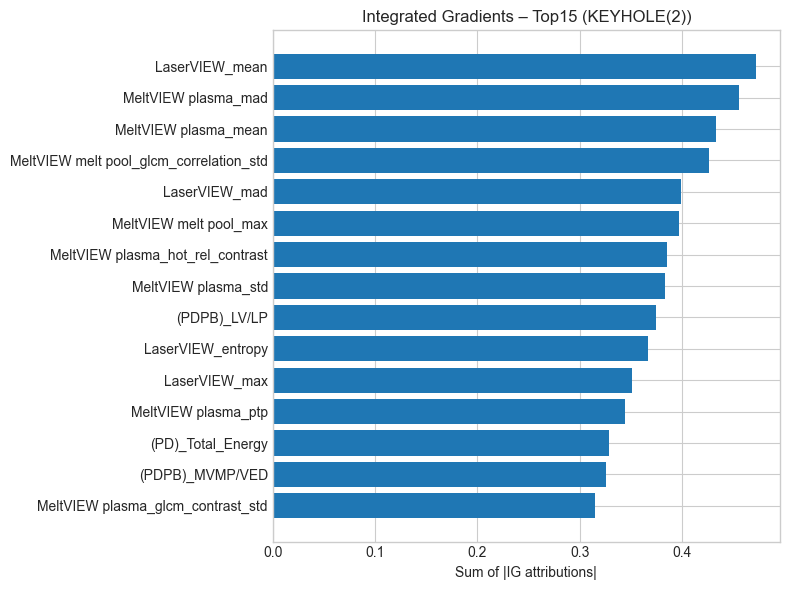

------------------------------------------------------------


In [12]:
'''Cell 11. Feature importance '''
# --- Captum Integrated Gradients on the full validation batch ---
#from captum.attr import IntegratedGradients
#import torch
#import numpy as np
#import matplotlib.pyplot as plt

# 0. Check that both model and val_loader exist
if ( 'model' in globals() and model is not None
     and 'val_loader' in globals() and val_loader is not None ):

    # 1. Ensure model on device & eval
    model.to(device)
    model.eval()

    # 2. Grab the one validation batch
    batch = next(iter(val_loader))
    sequences = batch['sequences'].to(device)  # [B, T, F]
    lengths   = batch['lengths']               # used inside forward
    masks     = batch['masks'].to(device)      # [B, T]

    # 3. Define zero baseline (features were standardized to mean=0)
    baseline_sequences = torch.zeros_like(sequences)

    # 4. Forward wrapper capturing lengths & masks
    def forward_wrapper(inp_sequences):
        return model(inp_sequences, lengths, masks)

    # 5. Instantiate Integrated Gradients
    ig = IntegratedGradients(forward_wrapper)

    # 6. Loop over each class
    for target_idx, class_name in enumerate(target_names):
        print(f"\n→ IG for class {class_name} (idx={target_idx})")

        # a) Compute attributions
        model.train()  # workaround for some cuDNN backward quirks
        attributions = ig.attribute(
            sequences,
            baselines=baseline_sequences,
            target=target_idx,
            return_convergence_delta=False,
            internal_batch_size=sequences.size(0)
        )
        model.eval()

        # b) Mask padding & sum abs attributions
        at_abs   = attributions.abs()
        mask_exp = masks.unsqueeze(-1).float()     # [B, T, 1]
        at_mask  = at_abs * mask_exp               # zero‐out pad steps
        feat_imp = at_mask.sum(dim=(0,1)).cpu().numpy()  # [F]

        # c) Map back to feature_cols or show indices
        if feature_cols and len(feature_cols) == feat_imp.shape[0]:
            fmap = dict(zip(feature_cols, feat_imp))
            sorted_feats = sorted(fmap.items(), key=lambda kv: kv[1], reverse=True)
            print("  Top 15 features:")
            for rank, (feat, score) in enumerate(sorted_feats[:15], 1):
                print(f"    {rank:2d}. {feat}: {score:.4f}")

            # d) Bar-plot
            top15 = sorted_feats[:15]
            names = [n for n,_ in top15][::-1]
            scores = [s for _,s in top15][::-1]
            plt.figure(figsize=(8,6))
            plt.barh(names, scores)
            plt.xlabel("Sum of |IG attributions|")
            plt.title(f"Integrated Gradients – Top15 ({class_name})")
            plt.tight_layout()
            plt.show()
        else:
            print("  ⚠️ feature_cols missing/mismatched — showing by index")
            idxs = np.argsort(feat_imp)[::-1][:15]
            for rank, idx in enumerate(idxs, 1):
                print(f"    {rank:2d}. Feature idx {idx}: {feat_imp[idx]:.4f}")

        print("-" * 60)

else:
    print("⚠️ Skipped IG: model/val_loader not available or Captum missing")
